<a href="https://colab.research.google.com/github/yangkeyin/NN-Complex-Singularity/blob/main/%E5%AE%9E%E9%AA%8C_20260123_%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E8%A7%A3%E6%9E%90%E5%8C%BA%E5%9F%9F%E5%92%8C%E9%A2%91%E8%B0%B1%E7%B3%BB%E6%95%B0%E7%9A%84%E5%85%B3%E7%B3%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 实验目的：
在深度神经网络函数上验证解析区域和频谱系数的关系：因为我们已经了解到，在多项式拟合理论中，随着多项式阶数的增加，解析函数和多项式之间的误差会乘指数衰减，且衰减系数和目标函数的解析区域有关。然而，我们并不清楚该理论在神经网络函数上是否同样成立，主要原因在于神经网络是个黑盒，我们很难用函数直接计算出奇点，而且之前尝试计算出奇点并推出衰减系数时，这个实际系数和理想系数也不匹配。所以这次尝试反向操作，既然难以通过函数直接计算出奇点，那么就通过衰减系数反向计算出奇点，并将计算出的理想奇点和实际奇点图进行匹配。



## 操作步骤：
首先选择龙格函数作为训练的解析函数， $$f(x) = \frac{1}{1 + 25x^2}$$ ，已知该函数的最近奇点为 $$\pm0.2i$$。从【-1，1】之间均匀采样2000个数据点作为实数训练集。(不错，预判了我要问采样方式)
再使用一层MLP（这是啥）（多层感知机，每一层是一个全连接层）作为训练模型，为了保持函数的解析特性，选择激活函数为tanh，学习率为1e-4，训练轮次为5000

模型训练完成后，绘制训练的loss图、奇点图和频谱系数图
- loss图就是将训练过程中的均方误差 vs epoch
- 奇点图的计算是这样的：采样复平面的网格数据，扔给训练好的模型，就可以得到复平面上的输出，我们将这个输出看成（u+vi），那么就可以在复平面上绘制出网络模型的输出热力图了，热力图用log( $$\sqrt{u^2+v^2}$$)表示。
- 频谱系数图：将2000个训练点的实际输出和预测输出分别用切比雪夫变换，得到输出的切比雪夫系数，便可以得到切比雪夫系数 vs 频率的关系了，据trefethen定理可知，切比雪夫系数的对数随频率的衰减率为 $$\rho$$， $$\rho $$和椭圆区域长半轴和短半轴有关系$$a = \frac{1}{2}(\rho + \frac{1}{\rho})$$  $$b = \frac{1}{2}(\rho - \frac{1}{\rho})$$。将计算出的目标椭圆区域和实际椭圆区域一起绘制在奇点图上。

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from sklearn.linear_model import LinearRegression

# 1. 构建目标函数 (Runge Function)
def runge_function(x):
    return 1 / (1 + 25 * x**2)

# 2. 定义 MLP 模型
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=128):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

# ----------------- 训练部分 -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP(hidden_size=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

x_train = torch.cos(torch.pi * torch.linspace(0, 1, 2000)).view(-1, 1).to(device)
y_train = runge_function(x_train)

losses = []
print("正在训练神经网络...")
for epoch in range(8000):
    optimizer.zero_grad()
    loss = criterion(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 2000 == 0: print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# ----------------- 3. 频谱分析与衰减拟合 -----------------
def get_chebyshev_coeffs(f_vals):
  """
  args:
  f_vals: np or tensor, (N,), function number
  return:
  coeffs: np, (N,), chebyshev coefficients
  """
  N = len(f_vals)
  coeffs = dct(f_vals, type=1) / (N - 1)
  coeffs[0] /= 2
  coeffs[-1] /= 2
  return np.abs(coeffs)


def calculate_envelope_slope(coeffs, n_bins=20, threshold=1e-12, start_k=0):
    """
    通过将频谱划分为若干个箱子（Bins），提取每个箱子内的局部最大值（包络线点），
    并对这些点进行对数线性回归，从而计算收敛率 $\rho$ 的上界斜率。

    参数 (Args):
        coeffs: np.ndarray, 形状 (N,), 意义: 切比雪夫展开系数的模长 $|c_k|$。
        n_bins: int, 意义: 将全频谱划分为多少个区间来寻找局部极大值。
        threshold: float, 意义: 过滤底噪的阈值，低于此值的系数不参与拟合。
        start_k: int, 意义: 设置从第几个阶数开始计算频谱系数，用于避开不稳定的低频段。

    返回 (Returns):
        envelope_slope: float, 意义: 线性拟合的斜率，对应 $-\ln(\rho)$。
    """
    # 根据 coeffs 的索引生成隐含的阶数 degrees (0 到 N-1)
    # 类型: np.ndarray, 形状: (N,)
    degrees = np.arange(len(coeffs))

    # 1. 预处理：去掉极小值（底噪）以防 log(0) 报错或干扰拟合
    # valid_mask 形状: (N,), 布尔类型
    k_mask = (degrees >= start_k)
    t_mask = (coeffs > threshold)
    valid_mask = k_mask & t_mask

    # 如果截断后没有足够的数据点，直接返回
    if np.sum(valid_mask) < 2:
        return 0.0, 0.0

    # valid_coeffs 形状: (N_valid,), 意义: 取对数后的有效系数
    valid_coeffs = np.log(coeffs[valid_mask])

    # valid_degrees 形状: (N_valid,), 意义: 有效系数对应的阶数
    valid_degrees = degrees[valid_mask]

    # 2. 对 degrees 进行分段（Binning）
    # bins 形状: (n_bins + 1,), 定义了每个箱子的边界坐标
    bins = np.linspace(valid_degrees.min(), valid_degrees.max(), n_bins + 1)

    # which_bin 形状: (N_valid,), 意义: 标记每个有效阶数属于哪个箱子
    which_bin = np.digitize(valid_degrees, bins)

    peak_x = []
    peak_y = []

    # 3. 遍历每一个箱子，寻找局部极大值
    for i in range(1, n_bins + 1):
        # 找出属于当前箱子 i 的点
        mask = (which_bin == i)

        if np.any(mask):
            # 获取该箱子内所有的对数系数值
            existing_peaks = valid_coeffs[mask]

            # 找到该箱子内最大的系数索引
            peak_idx = np.argmax(existing_peaks)

            # 记录该极大值对应的阶数 (x) 和对数值 (y)
            peak_x.append(valid_degrees[mask][peak_idx])
            peak_y.append(existing_peaks[peak_idx])

    # 4. 对提取出的包络线局部最大值进行线性拟合
    # peak_x 转换为列向量以适配 sklearn, 形状: (M, 1)
    peak_x = np.array(peak_x).reshape(-1, 1)
    # peak_y 形状: (M,)
    peak_y = np.array(peak_y)

    if len(peak_x) > 1:
        reg = LinearRegression()
        reg.fit(peak_x, peak_y)

        # 线性方程为: ln|c_k| = -ln(rho) * k + b
        # 因此 slope = -reg.coef_[0]
        envelope_slope = -reg.coef_[0]
        intercept = reg.intercept_
    else:
        # 如果点数太少无法拟合，返回 0
        envelope_slope, intercept = 0.0, 0.0

    return envelope_slope, intercept

# 计算频谱
N_sample = 100
x_cheb = np.cos(np.pi * np.arange(N_sample) / (N_sample - 1)) # shape[100,], numpy, cheb extreme points
y_target = runge_function(x_cheb) # shape[100,], taget output
with torch.no_grad():
    y_model = model(torch.tensor(x_cheb).float().view(-1, 1).to(device)).cpu().numpy().flatten() # shape[100,], predicted output

coeffs_target = get_chebyshev_coeffs(y_target) # shape(100,) target cheb coeffs
coeffs_model = get_chebyshev_coeffs(y_model) # shape(100, ) predicted cheb coeffs
slope_t, intercept_t = calculate_envelope_slope(coeffs_target, start_k=40)
slope_m, intercept_m = calculate_envelope_slope(coeffs_model, start_k=40)
# 计算用于绘图的阶数范围 (k)
k_fit = np.arange(len(coeffs_target))

# 根据线性方程 y = mx + b 计算对数拟合值，然后指数化
line_target = np.exp(-slope_t * k_fit + intercept_t) # numpy, shape(100,) exponent target coeffs line
line_model = np.exp(-slope_m * k_fit + intercept_m) # numpy, shape(100,) exponent model coeffs line

# ----------------- 4. 伯恩斯坦椭圆与解析延拓 -----------------
def get_ellipse_pts(rho, n_pts=200):
    theta = np.linspace(0, 2*np.pi, n_pts)
    # z = 0.5 * (rho * exp(it) + 1/rho * exp(-it))
    z = 0.5 * (rho * np.exp(1j * theta) + (1/rho) * np.exp(-1j * theta))
    b = 0.5 * (rho - 1/rho) # 短半轴
    return z.real, z.imag, b

def complex_inference(model, complex_grid):
    z = torch.tensor(complex_grid, dtype=torch.complex64).to(device)
    layers = list(model.net.children())
    curr = z.unsqueeze(-1)
    for layer in layers:
        if isinstance(layer, nn.Linear):
            W, b = layer.weight.to(torch.complex64), layer.bias.to(torch.complex64)
            curr = torch.matmul(curr, W.t()) + b
        elif isinstance(layer, nn.Tanh):
            curr = torch.tanh(curr)
    return torch.abs(curr).squeeze().detach().cpu().numpy()

# 准备绘图数据
res = 400
x_val, y_val = 1.5, 0.8
X, Y = np.meshgrid(np.linspace(-x_val, x_val, res), np.linspace(-y_val, y_val, res))
output_abs = complex_inference(model, X + 1j * Y)


<>:73: SyntaxWarning: invalid escape sequence '\l'
<>:73: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-290691415.py:73: SyntaxWarning: invalid escape sequence '\l'
  envelope_slope: float, 意义: 线性拟合的斜率，对应 $-\ln(\rho)$。


正在训练神经网络...
Epoch 0, Loss: 9.78e-02
Epoch 2000, Loss: 2.01e-04
Epoch 4000, Loss: 3.19e-06
Epoch 6000, Loss: 9.57e-07


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


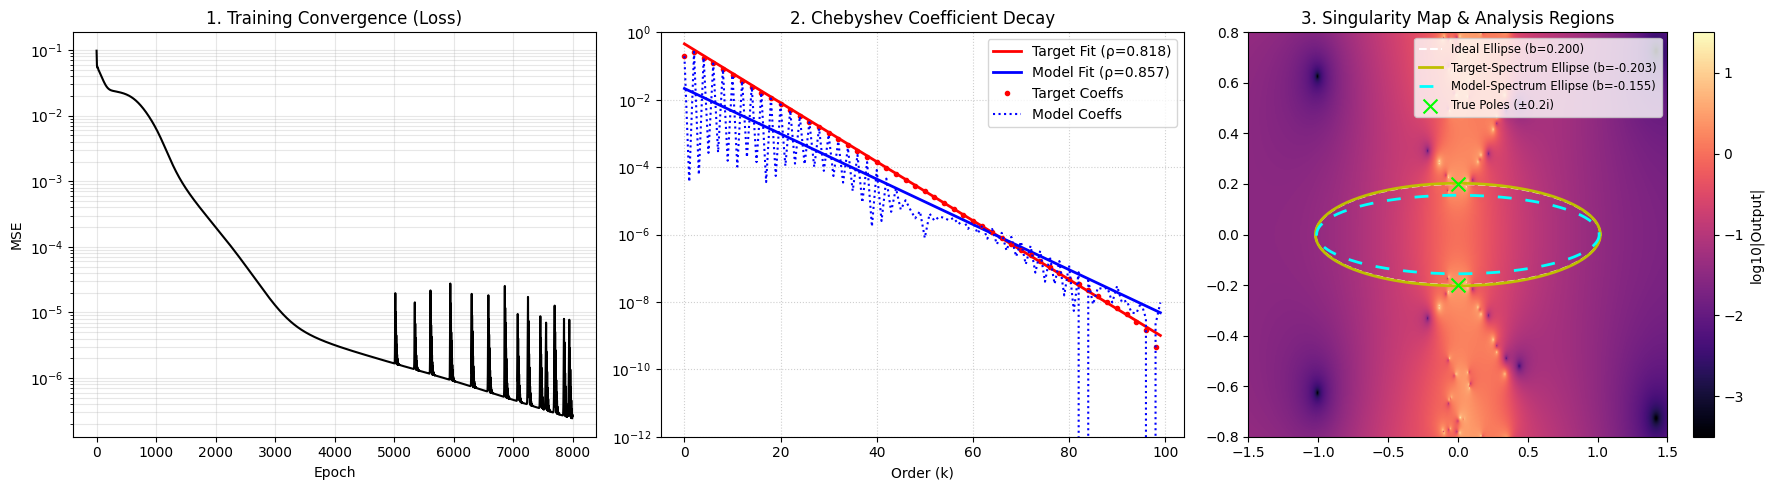

In [29]:
# ----------------- 5. 绘图 -----------------
plt.figure(figsize=(18, 5))

# 图 1: Loss 图
plt.subplot(1, 3, 1)
plt.semilogy(losses, color='black', lw=1.5)
plt.title("1. Training Convergence (Loss)", fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True, which="both", alpha=0.3)

# 图 2: 频谱系数衰减图
# 还原出需要的 rho (用于伯恩斯坦椭圆)
rho_target = np.exp(-slope_t)
rho_model = np.exp(-slope_m)
plt.subplot(1, 3, 2)
k_idx = np.arange(len(coeffs_target))
plt.semilogy(k_idx, line_target, 'r-', lw=2, label=f'Target Fit (ρ={rho_target:.3f})')
plt.semilogy(k_idx, line_model, 'b-', lw=2, label=f'Model Fit (ρ={rho_model:.3f})')
plt.semilogy(k_idx, coeffs_target, 'r.', label='Target Coeffs')
plt.semilogy(k_idx, coeffs_model, 'b:', label='Model Coeffs')
plt.ylim(1e-12, 1)
plt.title("2. Chebyshev Coefficient Decay", fontsize=12)
plt.xlabel("Order (k)")
plt.legend()
plt.grid(True, ls=":", alpha=0.6)

# 图 3: 综合奇点与区域验证图
plt.subplot(1, 3, 3)
im = plt.imshow(np.log10(output_abs + 1e-10), extent=[-x_val, x_val, -y_val, y_val],
                origin='lower', cmap='magma', aspect='auto', vmin=-3.5,vmax=1.5)
plt.colorbar(im, label="log10|Output|")

# 绘制三种区域
# A. 理论极点对应的理想椭圆 (针对 ±0.2i)
# Runge 极点在 0.2i -> rho = 0.2 + sqrt(0.2^2 + 1)
rho_ideal = 0.2 + np.sqrt(0.2**2 + 1)
ix, iy, ib = get_ellipse_pts(rho_ideal)
plt.plot(ix, iy, 'w--', lw=1.5, label=f'Ideal Ellipse (b={ib:.3f})')

# B. 通过目标函数频谱计算出的椭圆
tx, ty, tb = get_ellipse_pts(rho_target)
plt.plot(tx, ty, 'y-', lw=2, label=f'Target-Spectrum Ellipse (b={tb:.3f})')

# C. 通过神经网络频谱计算出的椭圆
mx, my, mb = get_ellipse_pts(rho_model)
plt.plot(mx, my, 'cyan', linestyle=(0, (5, 5)), lw=2, label=f'Model-Spectrum Ellipse (b={mb:.3f})')

# 标记真实极点
plt.scatter([0, 0], [0.2, -0.2], color='lime', marker='x', s=100, label='True Poles (±0.2i)', zorder=5)

plt.title("3. Singularity Map & Analysis Regions", fontsize=12)
plt.xlim(-x_val, x_val)
plt.ylim(-y_val, y_val)
plt.legend(fontsize='small', loc='upper right')

plt.tight_layout()

from google.colab import drive
import os

save_dir = "/content/drive/MyDrive/NN-Complex-Singularity"
drive.mount('/content/drive')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存到云端硬盘的根目录或指定文件夹
plt.savefig("/content/drive/MyDrive/NN-Complex-Singularity/singularity_analysis.svg", format="svg", bbox_inches='tight')